In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Read the data
data = pd.read_csv("survey lung cancer.csv")

In [3]:
# View the data
print(data.shape)
print(data.info())
print(data.head())

(309, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER  

In [4]:
# Check if there is null value
data.isna().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()

# Clean the data
data["GENDER"] = data["GENDER"].replace({"M" : "Male" , "F" : "Female"})
data["LUNG_CANCER"] = LabelEncoder.fit_transform(data["LUNG_CANCER"])

data = pd.get_dummies(data, columns= ["GENDER"])
data.rename(columns={"GENDER_Male" : "MALE", "GENDER_Female" : "FEMALE", "YELLOW_FINGERS" : "YELLOW FINGERS", "PEER_PRESSURE" : "PEER PRESSURE", "LUNG_CANCER" : "LUNG CANCER", "FATIGUE " : "FATIGUE", "ALLERGY " : "ALLERGY"}, inplace=True)
data = data[["AGE","MALE","FEMALE","ALCOHOL CONSUMING","CHEST PAIN","SHORTNESS OF BREATH","COUGHING","PEER PRESSURE","CHRONIC DISEASE","SWALLOWING DIFFICULTY","YELLOW FINGERS","ANXIETY","FATIGUE","ALLERGY","WHEEZING","LUNG CANCER"]]
# Store feature names
feature_names = data.columns.tolist()

In [6]:
# Logistic Regression Model

x = data.drop("LUNG CANCER", axis = 1)
y = data["LUNG CANCER"]

scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state = 42)
lr.fit(x_train, y_train)

y_pred = np.expm1(lr.predict(x_test))
# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test))**2))
print("RMSLE of Logistic Regression Model:",rmsle)
# Calculate the accuracy score
lr_pred = lr.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy of Logistic Regression Model:", lr_accuracy)

RMSLE of Logistic Regression Model: 0.3368692081079343
Accuracy of Logistic Regression Model: 0.967741935483871


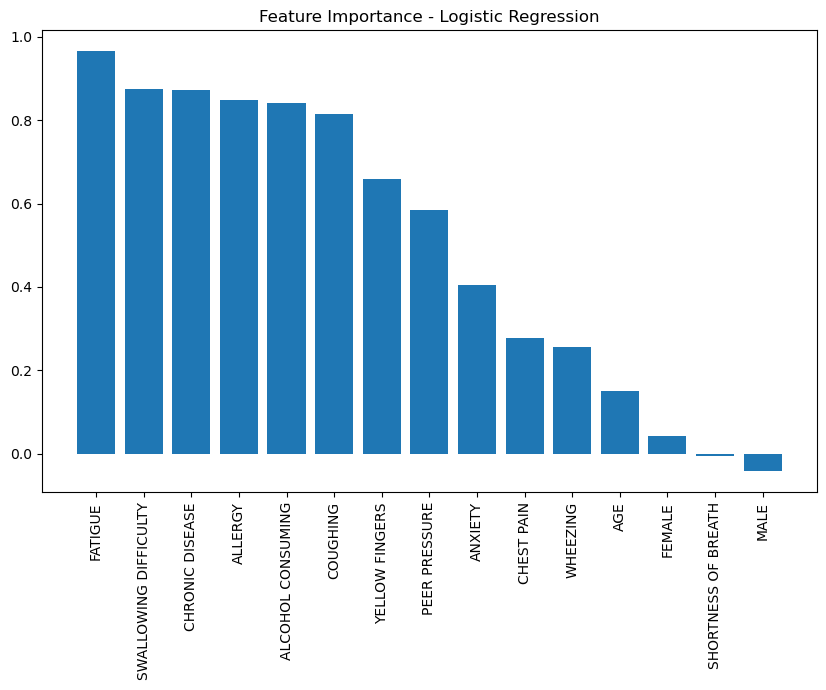

In [7]:
# Retrieve coefficients from the logistic regression model
coefficients = lr.coef_[0]

# Sort coefficients in descending order
indices = np.argsort(coefficients)[::-1]

# Rearrange feature names so they match the sorted coefficients
names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Logistic Regression")
plt.bar(range(x.shape[1]), coefficients[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

In [8]:
# LASSO Model

# Instantiate Lasso model with random_state = 76, tol=0.001
model_LASSO_cv = Lasso(random_state = 76, tol=0.001)

# Instantiate the GridSearchCV object and run the search on a grid of 
# alpha values from 10^{-4} = 0.0001 to 10^{-1} = 0.1
parameters = {'alpha':pow(10, np.linspace(-4, -1, num=100))}

searcher = GridSearchCV(model_LASSO_cv, parameters, scoring = 'neg_mean_squared_error')
searcher.fit(x_train, y_train)

# Fit LASSO model with appropriate hyperparameters
model_LASSO = Lasso(alpha = searcher.best_params_['alpha'], random_state = 76)
model_LASSO.fit(x_train, y_train)

# Print RMSLE score on training data
y_pred = np.expm1(model_LASSO.predict(x_test))
rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test))**2))
print("RMSLE of LASSO Model:",rmsle)
# Calculate the accuracy score
lasso_pred = model_LASSO.predict(x_test)
lasso_pred_class = np.where(lasso_pred > 0.5, 1, 0)  # Assuming binary classification
lasso_accuracy = accuracy_score(y_test, lasso_pred_class)
print("Accuracy of LASSO Model:", lasso_accuracy)

RMSLE of LASSO Model: 0.3091166557628747
Accuracy of LASSO Model: 0.967741935483871


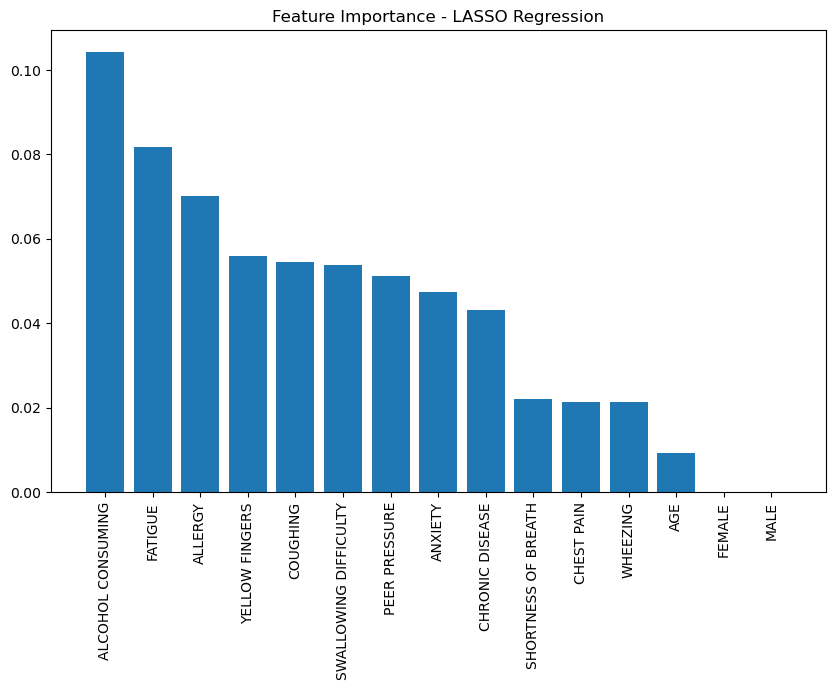

In [9]:
# Retrieve coefficients from the LASSO model
coefficients = model_LASSO.coef_

# Sort coefficients in descending order
indices = np.argsort(coefficients)[::-1]

# Rearrange feature names so they match the sorted coefficients
names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - LASSO Regression")
plt.bar(range(x.shape[1]), coefficients[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

In [10]:
# Random Forests Model

# Identify optimal value of complexity hyperparameter
param_grid = {"max_features": np.arange(1, 16, 1)}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_cv = GridSearchCV(rf, param_grid, cv=kf, n_jobs = -1, scoring = 'neg_mean_squared_error')
rf_cv.fit(x_train, y_train)

# Fit Random Forests model with appropriate hyperparameters
rf_best = RandomForestRegressor(n_estimators=1000, max_features=rf_cv.best_params_['max_features'], random_state=42)
rf_best.fit(x_train, y_train)  # Applying log transformation to the target variable

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
predictions = rf_best.predict(x_test)
#rmsle = np.sqrt(np.mean((np.log1p(predictions) - np.log1p(y_test))**2))
rmsle = np.sqrt(np.mean((np.log1p(y_test) - predictions) ** 2))
print("RMSLE of Random Forests Model:",rmsle)

# Random Forest Model
rf_pred = rf_best.predict(x_test)
rf_pred_class = np.where(rf_pred > 0.5, 1, 0)  # Assuming binary classification
rf_accuracy = accuracy_score(y_test, rf_pred_class)
print("Accuracy of Random Forest Model:", rf_accuracy)

# # Predict on the test set
# predictions = rf_best.predict(x_test)
# predictions_original_scale = np.expm1(predictions)

RMSLE of Random Forests Model: 0.27328794805159917
Accuracy of Random Forest Model: 0.9838709677419355


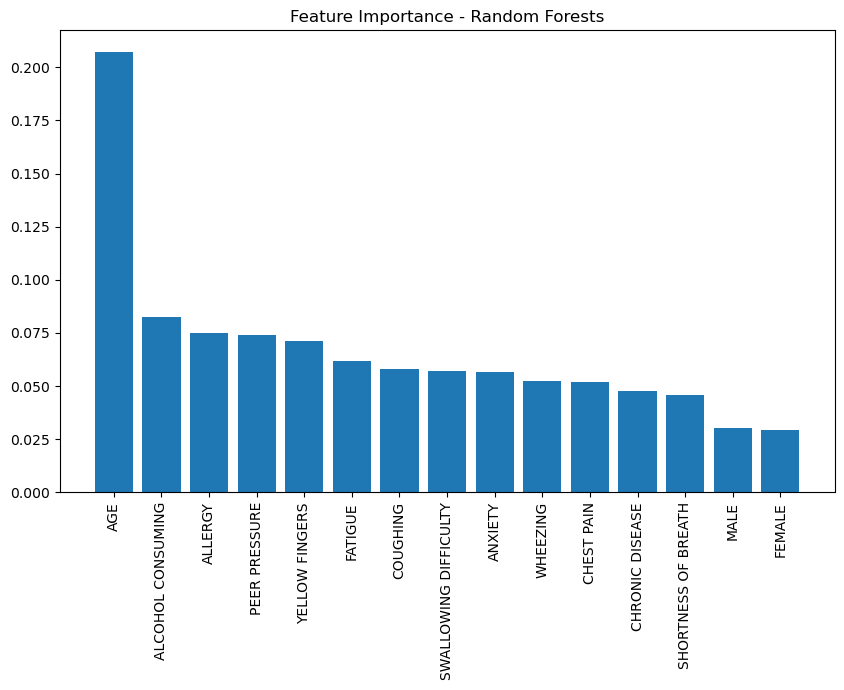

In [11]:
# Get feature importances
importances = rf_best.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forests")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

In [12]:
# SVM Model

# Define the grid of parameters to search
param_grid = {'C': [0.1, 1, 10, 100]}

# Perform grid search with cross-validation
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

svm_best = SVC(C = grid_search.best_params_['C'], random_state=42)
svm_best.fit(x_train, y_train)

predictions = svm_best.predict(x_test)
rmsle = np.sqrt(np.mean((np.log1p(y_test) - predictions) ** 2))
print("RMSLE of SVM Model:",rmsle)

svm_pred = svm_best.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Accuracy of SVM Model:", svm_accuracy)

RMSLE of SVM Model: 0.3459933779465698
Accuracy of SVM Model: 0.9516129032258065


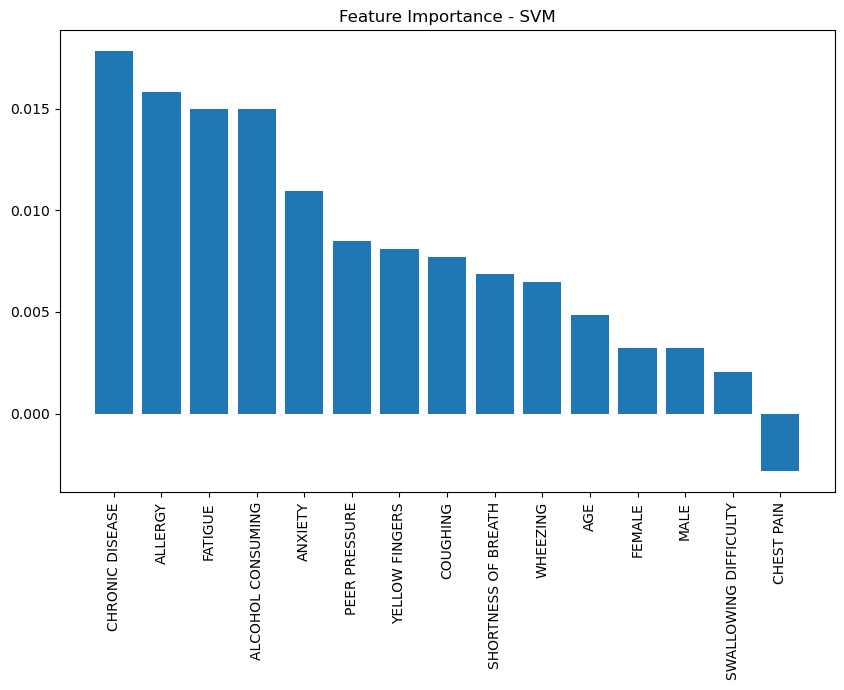

In [13]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(svm_best, x_train, y_train, n_repeats=10, random_state=42)

# Get feature importances and indices
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
importances_sorted = importances[indices]

# Rearrange feature names so they match the sorted coefficients
names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - SVM")
plt.bar(range(x.shape[1]), importances_sorted)
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()